In [1]:
!pip install matplotlib scikit-learn lightgbm --quiet

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [3]:
df_results = pd.read_csv("data/results.csv")
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [4]:
df_iso = pd.read_csv("data/iso.csv")
df_iso.head()

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM
2,Yemen,YE,YEM,887,ISO 3166-2:YE
3,Western Sahara,EH,ESH,732,ISO 3166-2:EH
4,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF


In [5]:
df_elo = pd.read_csv("data/elo.csv", index_col=0)
df_elo.head()

,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
EN,2146.0,2145.0,2212.0,2173.0,2067.0,2067.0,2067.0,2067.0,2067.0,2036.0,...,1960.0,1929.0,1933.0,1960.0,1956.0,1962.0,2032.0,1967.0,2015.0,2000.0
DK,2017.0,2009.0,2033.0,2051.0,2069.0,2074.0,2044.0,2041.0,2019.0,1974.0,...,1727.0,1716.0,1841.0,1898.0,1891.0,1927.0,1937.0,1883.0,1825.0,1826.0
AR,1956.0,1952.0,1939.0,1957.0,1948.0,1953.0,1981.0,1987.0,1998.0,1940.0,...,2023.0,2045.0,1984.0,1914.0,1967.0,1991.0,2101.0,2143.0,2138.0,2139.0
UY,1935.0,1939.0,1952.0,1936.0,1933.0,1928.0,1904.0,1956.0,1945.0,1988.0,...,1947.0,1914.0,1866.0,1923.0,1966.0,1953.0,1847.0,1905.0,2007.0,1992.0
NL,1915.0,1932.0,1967.0,1948.0,1952.0,1952.0,1952.0,1952.0,1952.0,1920.0,...,1898.0,1889.0,1895.0,1985.0,2017.0,1994.0,1929.0,2073.0,1970.0,1968.0


---

In [6]:
def remove_extras_and_add_year(df_results: pd.DataFrame) -> pd.DataFrame:
    df = df_results[["date", "home_team", "away_team", "home_score", "away_score", "tournament"]].copy()
    df = df.dropna(axis=0)
    
    df["year"] = df["date"].apply(lambda x: x[:4])
    df["is_friendly"] = df["tournament"].apply(lambda x: True if x.lower() == "friendly" else False)
    
    return df.drop(columns=["date", "tournament"]) 

In [7]:
def remove_iso_columns(df_iso: pd.DataFrame) -> pd.DataFrame:
    return df_iso[["English short name lower case", "Alpha-2 code"]].rename(columns={
        "English short name lower case": "country",
        "Alpha-2 code": "code",
    })

In [8]:
def combine_results_and_iso(df_results: pd.DataFrame, df_iso: pd.DataFrame) -> pd.DataFrame:
    return pd.merge(
        left=pd.merge(
            left=df_results,
            right=df_iso,
            left_on="home_team",
            right_on="country",
            how="inner",
        ).drop(columns=["country", "home_team"]).rename(columns={
            "code": "home"
        }),
        right=df_iso,
        left_on="away_team",
        right_on="country",
        how="inner",
    ).drop(columns=["country", "away_team"]).rename(columns={
        "code": "away"
    })

In [9]:
def set_elos(
    df_combined: pd.DataFrame,
    df_elo: pd.DataFrame,
    min_year: int | str | None = None,
    max_goals: int | None = None,
) -> pd.DataFrame:
    if min_year is None:
        years = set(df_elo.columns)
    else:
        years = {c for c in df_elo.columns if c >= str(min_year)}

    countries = set(df_elo.index)
    
    df_filtered = df_combined[df_combined["year"].isin(years) & df_combined["home"].isin(countries) & df_combined["away"].isin(countries)]
    
    df_filtered.loc[:, "home_elo"] = df_filtered.apply(lambda row: df_elo.loc[row["home"], row["year"]], axis=1)
    df_filtered.loc[:, "away_elo"] = df_filtered.apply(lambda row: df_elo.loc[row["away"], row["year"]], axis=1)
    
    df_filtered = df_filtered.dropna()
    
    df_home = pd.DataFrame({
        "code": df_filtered["home"],
        "home": df_filtered["home_elo"].astype(int),
        "away": df_filtered["away_elo"].astype(int),
        "is_friendly": df_filtered["is_friendly"].astype(bool),
        "scored": df_filtered["home_score"].astype(int),
    })
    
    df_away = pd.DataFrame({
        "code": df_filtered["away"],
        "home": df_filtered["away_elo"].astype(int),
        "away": df_filtered["home_elo"].astype(int),
        "is_friendly": df_filtered["is_friendly"].astype(bool),
        "scored": df_filtered["away_score"].astype(int),
    })
    
    df_set_elos = pd.concat([df_home, df_away], ignore_index=True)
    
    if max_goals and max_goals > 0:
        df_set_elos = df_set_elos[df_set_elos["scored"] <= max_goals]
        
    return df_set_elos
    

In [10]:
def add_scoring_power(df_set_elos: pd.DataFrame) -> pd.DataFrame:
    df_power = df_set_elos[["code","scored"]].groupby("code").mean("scored").reset_index().rename(columns={"scored":"power"})
    
    return pd.merge(
        left=df_set_elos,
        right=df_power,
        how="inner",
        left_on="code",
        right_on="code",
    )

In [11]:
def create_dataset(df_powers: pd.DataFrame) -> pd.DataFrame:
    df = df_powers[["power", "is_friendly", "scored"]]
    df["elo_diff"] = df_powers.apply(lambda row: row["home"] - row["away"], axis=1)
    
    return df

---

In [12]:
def run_dataset_pipeline(
    df_results: pd.DataFrame, 
    df_iso: pd.DataFrame, 
    df_elo: pd.DataFrame,
    min_year: int | str | None = None,
    max_goals: int | None = None,
) -> pd.DataFrame:
    df_filtered_results = remove_extras_and_add_year(df_results)
    df_filtered_iso = remove_iso_columns(df_iso)
    
    df_combined = combine_results_and_iso(df_filtered_results, df_filtered_iso)
    del df_filtered_results, df_filtered_iso
    
    df_set_elos = set_elos(df_combined, df_elo, min_year=min_year, max_goals=max_goals)
    del df_combined
    
    df_powers = add_scoring_power(df_set_elos)
    del df_set_elos
    
    return create_dataset(df_powers)

In [13]:
def run_country_stats_pipeline(
    df_results: pd.DataFrame, 
    df_iso: pd.DataFrame, 
    df_elo: pd.DataFrame,
    min_year: int | str | None = None,
    max_goals: int | None = None,
) -> pd.DataFrame:
    df_filtered_results = remove_extras_and_add_year(df_results)
    df_filtered_iso = remove_iso_columns(df_iso)
    
    df_combined = combine_results_and_iso(df_filtered_results, df_filtered_iso)
    del df_filtered_results, df_filtered_iso
    
    df_set_elos = set_elos(df_combined, df_elo, min_year=min_year, max_goals=max_goals)
    del df_combined
    
    df_powers = df_set_elos[["code","scored"]].groupby("code").mean("scored").reset_index().rename(columns={"scored":"power"})
    del df_set_elos
    
    df_powers["elo"] = [df_elo.loc[country, "2024"] for country in df_powers["code"]]
    
    # Adding these back in here as to not disrupt the flow of the dataset pipeline
    country_lookup = df_iso.set_index("Alpha-2 code")["English short name lower case"]
    df_powers["name"] = [country_lookup.loc[code] for code in df_powers["code"]]
    
    return df_powers.set_index("code")

---

In [14]:
stats = run_country_stats_pipeline(
    df_results=df_results,
    df_iso=df_iso,
    df_elo=df_elo,
    min_year=2020,
    max_goals=10,
)
stats.head()

,power,elo,name
code,,,
AD,0.540541,1113.0,Andorra
AE,1.511628,1508.0,United Arab Emirates
AF,1.000000,1114.0,Afghanistan
AG,1.062500,1014.0,Antigua and Barbuda
AI,0.200000,603.0,Anguilla


In [15]:
df = run_dataset_pipeline(
    df_results=df_results,
    df_iso=df_iso,
    df_elo=df_elo,
    min_year=2016,
    max_goals=10,
)
df.sort_values("scored").head()

,power,is_friendly,scored,elo_diff
5817,1.412500,True,0,-207
8896,0.402985,False,0,-227
6783,0.956522,False,0,-419
8893,0.777778,False,0,-58
2837,0.384615,False,0,-541


---

Matplotlib is building the font cache; this may take a moment.


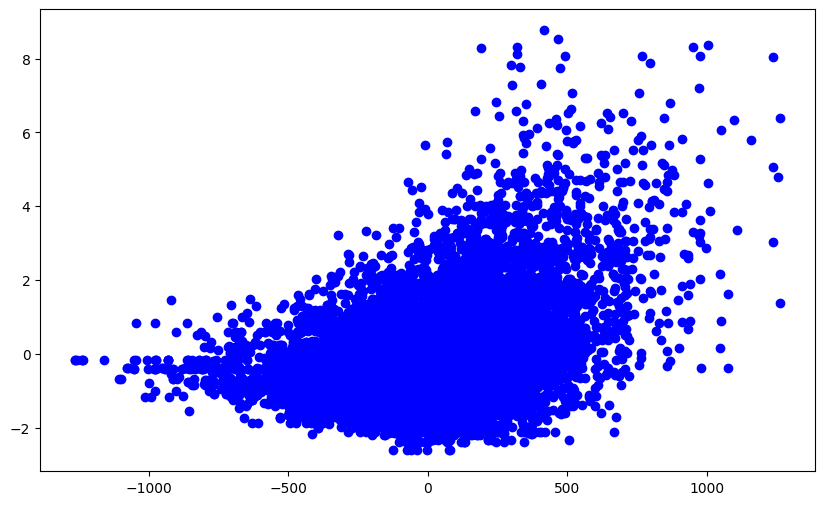

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df["elo_diff"], df["scored"] - df["power"], marker='o', color='blue')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 9991, number of used features: 2
[LightGBM] [Info] Start training from score -0.006077
Mean Squared Error: 1.5415910707535856
R-squared: 0.1940564610439296


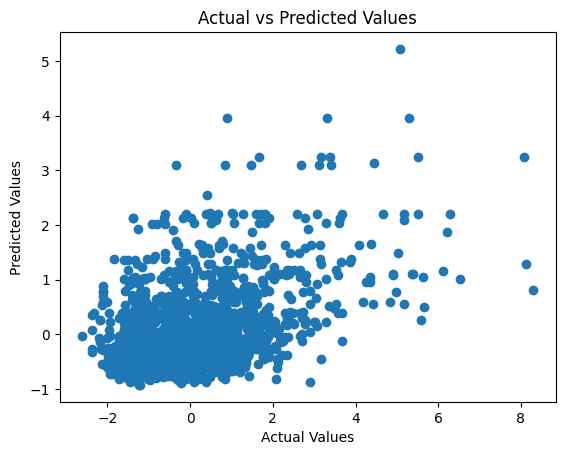

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# Features and target variable
X = df[['elo_diff', "is_friendly"]]
y = df['scored'] - df['power']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=444)


# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
lgb_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data])

# Make predictions
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Optional: Plot the predictions vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [18]:
lgb_model.save_model('lightgbm_model.txt')

Mean Squared Error: 1.465065143907384
R-squared: 0.1392504675901184
Coefficients: [0.00199561]
Intercept: 0.010921488859513832


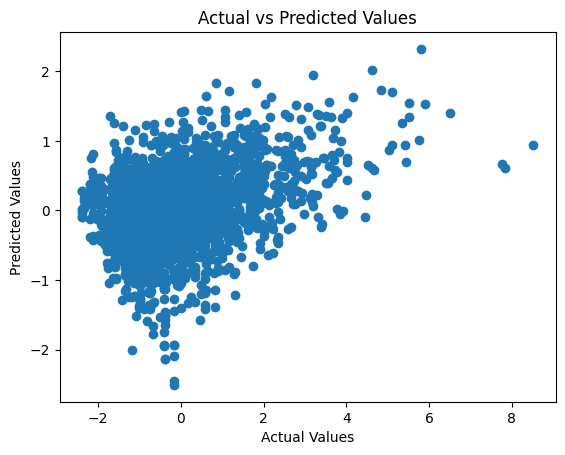

In [19]:
from sklearn.linear_model import LinearRegression

# Features and target variable
X = df[['elo_diff']]
y = df['scored'] - df['power']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train.values, y_train.values)

# Make predictions
y_pred = reg_model.predict(X_test.values)

# Evaluate the model
mse = mean_squared_error(y_test.values, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Print model coefficients
print('Coefficients:', reg_model.coef_)
print('Intercept:', reg_model.intercept_)

# Optional: Plot the predictions vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

---

In [20]:
from sklearn.linear_model._base import LinearRegression as SklearnRegressor
from lightgbm.basic import Booster as LgbBooster
from typing import Any, Literal
from functools import cached_property
from dataclasses import dataclass
import numpy as np
from scipy.stats import mode

@dataclass
class Team:
    elo: int
    power: float
    name: str

class ScorePredictor:
    def __init__(
        self,
        regressor: SklearnRegressor | None = None,
        booster: LgbBooster | None = None,
        default_samples: int = 5,
    ) -> None:
        if regressor is None and booster is None:
            raise ValueError("At least one of the regressor and booster must be set")
            
        self.default_samples = default_samples
        
        self.models: dict[Literal["linear", "gbm"], Any] = {}
        if regressor is not None:
            self.models["linear"] = regressor
        if booster is not None:
            self.models["gbm"] = booster
            
    @staticmethod
    def sample(lambda_: float, n_samples: int) -> int:            
        samples = np.random.poisson(lambda_, n_samples)
        return mode(samples, axis=None).mode
        
        
    def predict_linear(self, home: Team, away: Team) -> tuple[float, float]:
        elo_diff = home.elo - away.elo
        powers = self.models["linear"].predict(
            (
                (elo_diff, ), 
                (-elo_diff, )
            )
        )
        return max(home.power + powers[0], 0), max(away.power + powers[1], 0)
    
    def predict_gbm(self, home: Team, away: Team) -> tuple[float, float]:
        elo_diff = home.elo - away.elo
        powers = self.models["gbm"].predict(
            np.array((
                (elo_diff, False), 
                (-elo_diff, False)
            ))
        )
        return max(home.power + powers[0], 0), max(away.power + powers[1], 0)
        
    def predict(
        self, 
        home: Team, 
        away: Team, 
        model_type: Literal["linear", "gbm"] | None = None,
        n_samples: int | None = None,
        show_power: bool = False,
    ) -> tuple[int, int]:
        if n_samples is None or n_samples <= 0:
            n_samples = self.default_samples
            

        match model_type:
            case "linear":
                home_power, away_power = self.predict_linear(home=home, away=away)
            case "gbm":
                home_power, away_power = self.predict_gbm(home=home, away=away)
            case _:
                home_power, away_power = home.power, away.power
                
        if show_power:
            print(f"{home.name} {home_power} - {away_power} {away.name}")

        return (
            ScorePredictor.sample(home_power, n_samples=n_samples),
            ScorePredictor.sample(away_power, n_samples=n_samples)
        )
    
    def display_score(
        self, 
        home: Team, 
        away: Team, 
        model_type: Literal["linear", "gbm"] | None = None,
        n_samples: int | None = None,
        show_power: bool = False,
    ) -> str:
        goals = self.predict(
            home=home, 
            away=away, 
            model_type=model_type,
            n_samples=n_samples,
            show_power=show_power,
        )
        return f"{home.name} {goals[0]} - {goals[1]} {away.name}"
            

In [21]:
team_lookup = {
    ind: Team(power=stats.loc[ind].power, elo=stats.loc[ind].elo, name=stats.loc[ind]["name"]) for ind in stats.index
}
team_lookup["IT"]

Team(elo=1949.0, power=1.8604651162790697, name='Italy')

In [22]:
p = ScorePredictor(
    regressor=reg_model,
    booster=lgb_model,
)

In [23]:
n_samples = 7
home_team = "PL"
away_team = "NL"

home = team_lookup[home_team]
away = team_lookup[away_team]

print("Linear Model: ", p.display_score(home, away, n_samples=n_samples, model_type="linear", show_power=True))
# print("GBM Model:    ", p.display_score(home, away, n_samples=n_samples, model_type="gbm"))
# print("No Model:     ", p.display_score(home, away, n_samples=n_samples))

Poland 1.2621920773297688 - 2.731109674173614 Netherlands
Linear Model:  Poland 1 - 2 Netherlands


In [ ]:
while True:
    x = input("Home")
    
    if x.lower() == "exit":
        break
    
    y = input("Away")
    if y.lower() == "exit":
        break
        
    home = team_lookup[x]
    away = team_lookup[y]
    
    print(home, away)

    print("Linear Model: ", p.display_score(home, away, n_samples=n_samples, model_type="linear"))
    print("GBM Model:    ", p.display_score(home, away, n_samples=n_samples, model_type="gbm"))


Home PR
Away CZ


Team(elo=1130.0, power=2.3333333333333335, name='Puerto Rico') Team(elo=1772.0, power=1.6428571428571428, name='Czech Republic')
Linear Model:  Puerto Rico 1 - 3 Czech Republic
GBM Model:     Puerto Rico 2 - 3 Czech Republic


Home PR
Away CZ


Team(elo=1130.0, power=2.3333333333333335, name='Puerto Rico') Team(elo=1772.0, power=1.6428571428571428, name='Czech Republic')
Linear Model:  Puerto Rico 1 - 2 Czech Republic
GBM Model:     Puerto Rico 1 - 3 Czech Republic


Home PT
Away CZ


Team(elo=2015.0, power=2.595744680851064, name='Portugal') Team(elo=1772.0, power=1.6428571428571428, name='Czech Republic')
Linear Model:  Portugal 3 - 2 Czech Republic
GBM Model:     Portugal 2 - 0 Czech Republic


Home TR
Away GE


Team(elo=1757.0, power=2.0, name='Turkey') Team(elo=1650.0, power=1.5588235294117647, name='Georgia')
Linear Model:  Turkey 1 - 0 Georgia
GBM Model:     Turkey 2 - 2 Georgia


In [ ]:
R